In [1]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [1]:
import os
from datetime import datetime

import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms.v2 as transforms_v2
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_f1_score
)
from dl_utils import train_one_epoch, test, plot_predictions


2025-04-19 06:17:24.316952: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sirawichvac/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
####################
# Dataset
####################
# Define a transform
train_trans = transforms_v2.Compose([
    # TODO: Try to add/edit/remove other realistic transformation for training
    # See more from this link: https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html
    transforms_v2.ToImage(),  # Convert to tensor (C, H, W), only needed if you had a PIL image
    transforms_v2.RandomResizedCrop(size=(224, 224), antialias=True),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.ToDtype(torch.float32, scale=True),    # Converts the input to a type float32, and rescale from [0, 255] to [0, 1]
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize a tensor with mean and standard deviation.
])

test_trans = transforms_v2.Compose([
    transforms_v2.ToImage(),  # Convert to tensor (C, H, W), only needed if you had a PIL image
    transforms_v2.Resize(256),  # Resize to have the smallest dimension of 72 while maintaining aspect ratio
    transforms_v2.CenterCrop(224),  # Center crop an image to be 64x64
    transforms_v2.ToDtype(torch.float32, scale=True),    # Converts the input to a type float32, and rescale from [0, 255] to [0, 1]
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize a tensor with mean and standard deviation.
])

In [3]:
# TODO: Define DataSet for train, valid, and test
data_dir = './data/THFOOD50-v1'
print(f"Data directory: {data_dir}")

Data directory: ./data/THFOOD50-v1


In [4]:
#datasetcleaner
# import os
# from PIL import Image

# root_dir = data_dir

# # delete bad images (set to True to auto-delete)
# delete_corrupted = True

# def is_image_file(filename):
#     return any(filename.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])

# bad_files = []

# for root, _, files in os.walk(root_dir):
#     for file in files:
#         if is_image_file(file):
#             file_path = os.path.join(root, file)
#             try:
#                 with Image.open(file_path) as img:
#                     img.load()       # force decode image
#                     img.convert('RGB')  # simulate what PyTorch will do

#             except Exception as e:
#                 print(f"Corrupted: {file_path} ({e})")
#                 bad_files.append(file_path)
#                 if delete_corrupted:
#                     os.remove(file_path)
#                     print(f"Deleted: {file_path}")

# print(f"\n Scan complete. Found {len(bad_files)} bad image(s).")


In [4]:
torch.manual_seed(42)

train_ds = datasets.ImageFolder(
    root=os.path.join(data_dir, "train"),
    transform= train_trans 
)

valid_ds = datasets.ImageFolder(
    root=os.path.join(data_dir, "val"),
    transform= test_trans
)
valid_ds, test_ds = random_split(valid_ds, [0.8, 0.2])

# Dataset sizes
print(f"Train set: {len(train_ds)} samples")
print(f"Valid set: {len(valid_ds)} samples")
print(f"Test set: {len(test_ds)} samples")


Train set: 14168 samples
Valid set: 1280 samples
Test set: 320 samples


In [5]:
####################
# Hyperparameters
####################
learning_rate = 1e-3    # TODO: Change this as you see fit
batch_size = 16         # TODO: Change this as you see fit
epochs = 20              # TODO: Change this as you see fit


In [6]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [7]:
####################
# Model
####################
# Detect computing device on your computer
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
    
# Import the model class from model.py
from torchvision.models import resnet34, ResNet34_Weights

# Create a model
weights = ResNet34_Weights.DEFAULT
model = resnet34(weights=weights)

num_ftrs = model.fc.in_features

# Add Dropout and an intermediate layer for better regularization
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),  # 👈 Dropout to prevent overfitting
    nn.Linear(512, len(train_ds.classes))  # Final classification layer
)

model = model.to(device)

Using cuda device


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) (1): True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (2): True
ReLU(inplace=True) (3): True
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) (4): True
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3),

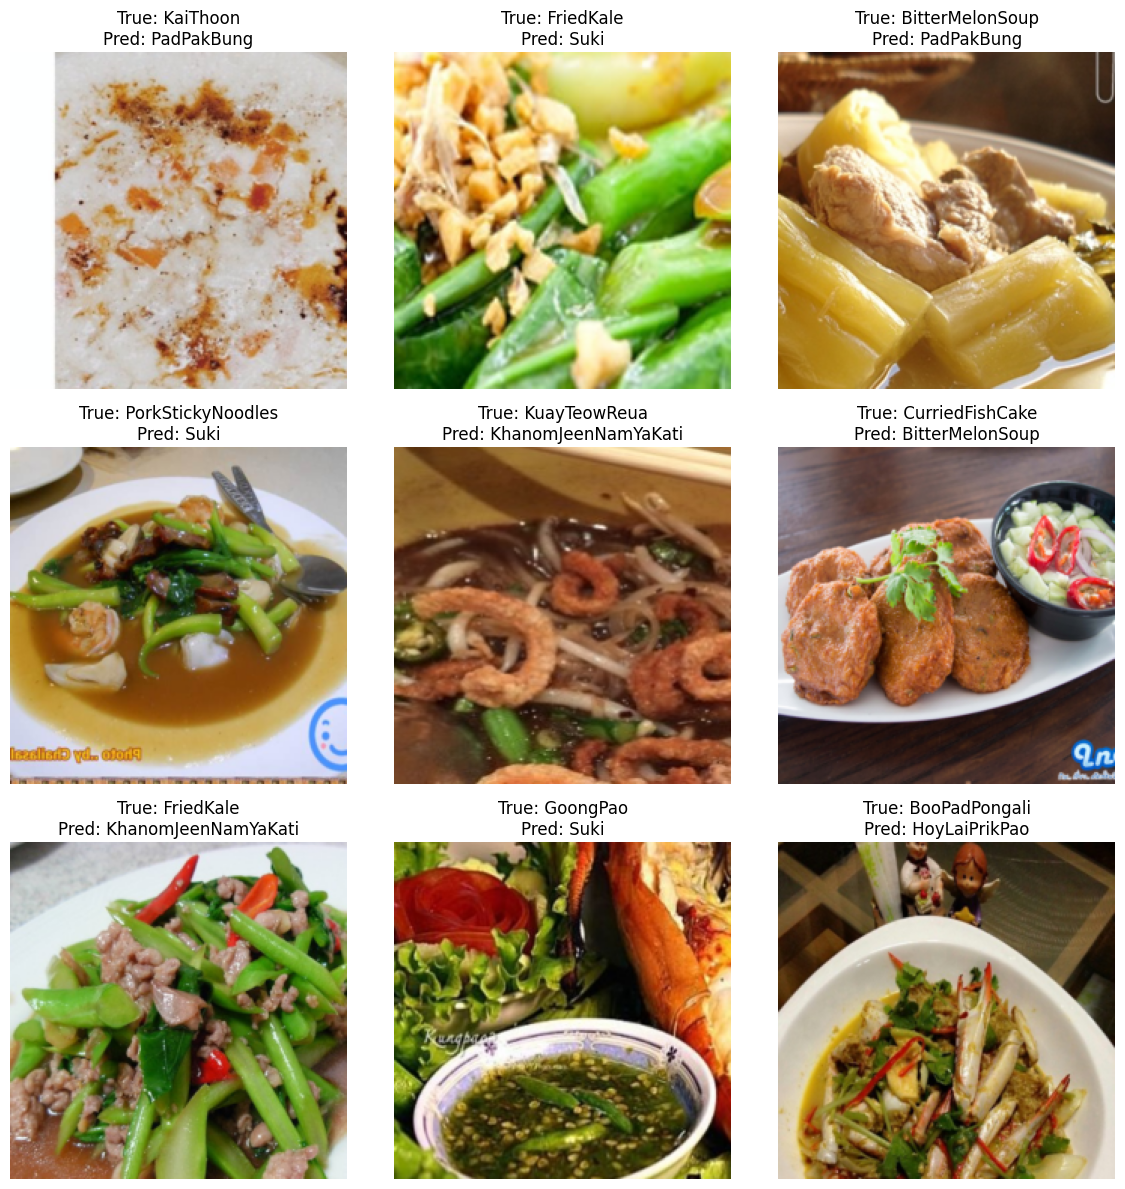

In [8]:
# TODO: Set `fine_tune_at` to specify how many layers to freeze
# Note: 
# - The lower the `fine_tune_at` value, the more layers are fine-tuned (or trained) from that layer onward until the last layer.
#     - `fine_tune_at=1` means you want to finetune all layers.
# - The number of layers varies depending on the model choice.
fine_tune_at = 1
ct = 0
for child in model.children():
    ct += 1
    if ct < fine_tune_at:
        for param in child.parameters():
            param.requires_grad = False
        print(f"{child} ({ct}): {False}")
    else:
        for param in child.parameters():
            param.requires_grad = True
        print(f"{child} ({ct}): {True}")

# Try to feed `batch_x` into the model to test the forward pass
batch_x, batch_y = next(iter(train_dl))
y_hat = model(batch_x.to(device))
y_pred = torch.argmax(y_hat, dim=1)  # this is optional
print(y_hat)
print(y_pred)  # this is optional

plot_predictions(batch_x, batch_y, y_pred, train_ds.classes)

In [9]:
####################
# Model Training
####################
# Setup tensorboard
writer = SummaryWriter(f'./runs/trainer_{model._get_name()}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [10]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

In [11]:
# Specify optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [12]:
# Training loop
best_vloss = 100000.
for epoch in range(epochs):
    print(f"Epoch {epoch+1} / {epochs}")
    train_one_epoch(train_dl, model, loss_fn, optimizer, epoch, device, writer, log_step_interval=1)
    train_loss, train_y_preds, train_y_trues = test(train_dl, model, loss_fn, device)
    val_loss, val_y_preds, val_y_trues = test(valid_dl, model, loss_fn, device)
    
    # Performance metrics
    train_perf = {
        'accuracy': multiclass_accuracy(train_y_preds, train_y_trues).item(),
        'f1': multiclass_f1_score(train_y_preds, train_y_trues).item(),
    }
    
    # Performance metrics
    val_perf = {
        'accuracy': multiclass_accuracy(val_y_preds, val_y_trues).item(),
        'f1': multiclass_f1_score(val_y_preds, val_y_trues).item(),
    }
    
    # Log model training performance
    writer.add_scalars('Train vs. Valid/loss', 
        {'train':train_loss, 'valid': val_loss}, 
        epoch)
    writer.add_scalars(
        'Performance/acc', 
        {'train':train_perf['accuracy'], 'valid': val_perf['accuracy']},
        epoch)
    writer.add_scalars(
        'Performance/f1', 
        {'train':train_perf['f1'], 'valid': val_perf['f1']},
        epoch)

    # Track best performance, and save the model's state
    if val_loss < best_vloss:
        best_vloss = val_loss
        torch.save(model.state_dict(), 'model_best_vloss.pth')
        print('Saved best model to model_best_vloss.pth')
print("Done!")

Epoch 1 / 20
loss: 4.038273  [   16/14168] | GPU: Allocated = 0.839 GB, Reserved = 1.420 GB
loss: 3.971887  [   32/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 4.008754  [   48/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 3.958794  [   64/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 4.051842  [   80/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 3.990274  [   96/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 3.861307  [  112/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 3.997176  [  128/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 3.921738  [  144/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 4.008853  [  160/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 3.886606  [  176/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 4.004043  [  192/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 3.918567  [  208/14168] | GPU: Al

loss: 2.967243  [ 1696/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.397593  [ 1712/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.899675  [ 1728/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.836490  [ 1744/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.893041  [ 1760/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.612903  [ 1776/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.344322  [ 1792/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.453530  [ 1808/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.715508  [ 1824/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.658283  [ 1840/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 3.103246  [ 1856/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.779558  [ 1872/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.271453  [ 1888/14168] | GPU: Allocated = 0.8

loss: 1.998228  [ 3360/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.256649  [ 3376/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.269339  [ 3392/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.697935  [ 3408/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.017728  [ 3424/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.632538  [ 3440/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.821465  [ 3456/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.312819  [ 3472/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.176913  [ 3488/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.869459  [ 3504/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.301053  [ 3520/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.152067  [ 3536/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.232424  [ 3552/14168] | GPU: Allocated = 0.8

loss: 2.131932  [ 5040/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.816533  [ 5056/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.679484  [ 5072/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.048913  [ 5088/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.948037  [ 5104/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.030137  [ 5120/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.199118  [ 5136/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.461332  [ 5152/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.777074  [ 5168/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.329586  [ 5184/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.576630  [ 5200/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.067641  [ 5216/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.455013  [ 5232/14168] | GPU: Allocated = 0.8

loss: 1.314242  [ 6736/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.854394  [ 6752/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.618435  [ 6768/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.612815  [ 6784/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.083864  [ 6800/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.216977  [ 6816/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.088760  [ 6832/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.126169  [ 6848/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.291815  [ 6864/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.461320  [ 6880/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.155148  [ 6896/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.311483  [ 6912/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.757653  [ 6928/14168] | GPU: Allocated = 0.8

loss: 1.929443  [ 8400/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.301724  [ 8416/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.345617  [ 8432/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.275296  [ 8448/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.718317  [ 8464/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.123199  [ 8480/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.710061  [ 8496/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.526439  [ 8512/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.343508  [ 8528/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.811357  [ 8544/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.627791  [ 8560/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.464942  [ 8576/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.989378  [ 8592/14168] | GPU: Allocated = 0.8

loss: 1.356450  [10080/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.115395  [10096/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.499721  [10112/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.756481  [10128/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.823344  [10144/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.350480  [10160/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.233418  [10176/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.896024  [10192/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.019512  [10208/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.508893  [10224/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.420892  [10240/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.417086  [10256/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.716826  [10272/14168] | GPU: Allocated = 0.8

loss: 1.158005  [11744/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.016213  [11760/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.507367  [11776/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.233869  [11792/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.421706  [11808/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 0.600835  [11824/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.039997  [11840/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.438187  [11856/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.091814  [11872/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.264762  [11888/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.107893  [11904/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.807995  [11920/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.913711  [11936/14168] | GPU: Allocated = 0.8

loss: 1.939277  [13424/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.008826  [13440/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.097870  [13456/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.743283  [13472/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.212811  [13488/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.886846  [13504/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.436737  [13520/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.145517  [13536/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.191474  [13552/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.460154  [13568/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.329208  [13584/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 2.404294  [13600/14168] | GPU: Allocated = 0.840 GB, Reserved = 1.484 GB
loss: 1.369362  [13616/14168] | GPU: Allocated = 0.8

/home/sirawichvac/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Saved best model to model_best_vloss.pth
Epoch 2 / 20
loss: 1.360039  [   16/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.073143  [   32/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.055404  [   48/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.250746  [   64/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.283044  [   80/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.454826  [   96/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.311524  [  112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.053328  [  128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.492010  [  144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.771258  [  160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.596009  [  176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.060107  [  192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 G

loss: 1.119247  [ 1680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.691363  [ 1696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.933003  [ 1712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.164052  [ 1728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.223974  [ 1744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.765941  [ 1760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.600444  [ 1776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.872594  [ 1792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.746047  [ 1808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.259768  [ 1824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.364619  [ 1840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.005814  [ 1856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.304769  [ 1872/14168] | GPU: Allocated = 0.8

loss: 1.106907  [ 3344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.722067  [ 3360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.386827  [ 3376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.290513  [ 3392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.295720  [ 3408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.032540  [ 3424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.548010  [ 3440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.574707  [ 3456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.188040  [ 3472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.631740  [ 3488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.068661  [ 3504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.163825  [ 3520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.055490  [ 3536/14168] | GPU: Allocated = 0.8

loss: 1.042902  [ 5040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.008310  [ 5056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.340653  [ 5072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.869169  [ 5088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.036117  [ 5104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.528580  [ 5120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.870082  [ 5136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.733146  [ 5152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.782778  [ 5168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.544070  [ 5184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.432330  [ 5200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.929377  [ 5216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.349773  [ 5232/14168] | GPU: Allocated = 0.8

loss: 1.172705  [ 6720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.020039  [ 6736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.808939  [ 6752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.259612  [ 6768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.979738  [ 6784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.594700  [ 6800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.054896  [ 6816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.298202  [ 6832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.524912  [ 6848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.930442  [ 6864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.099607  [ 6880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.196687  [ 6896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.858662  [ 6912/14168] | GPU: Allocated = 0.8

loss: 1.131255  [ 8400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.714964  [ 8416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.769053  [ 8432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.130891  [ 8448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.843087  [ 8464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.795871  [ 8480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.087204  [ 8496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.667408  [ 8512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.015450  [ 8528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.380186  [ 8544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.527396  [ 8560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.924345  [ 8576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.271558  [ 8592/14168] | GPU: Allocated = 0.8

loss: 1.678187  [10064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.784864  [10080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.999407  [10096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.904594  [10112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.001246  [10128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.252409  [10144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.900198  [10160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.988896  [10176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.079768  [10192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.193223  [10208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.265269  [10224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.395323  [10240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.197220  [10256/14168] | GPU: Allocated = 0.8

loss: 1.321108  [11744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.552314  [11760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.971008  [11776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.698298  [11792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.780766  [11808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.608702  [11824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.013737  [11840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.969724  [11856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.612165  [11872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.264696  [11888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.704471  [11904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.846885  [11920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.528498  [11936/14168] | GPU: Allocated = 0.8

loss: 0.556586  [13408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.302916  [13424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.162750  [13440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.121808  [13456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.246720  [13472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.728303  [13488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.651632  [13504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.577282  [13520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.620141  [13536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.213030  [13552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.921848  [13568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.506516  [13584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.713332  [13600/14168] | GPU: Allocated = 0.8

loss: 1.418308  [  912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.082471  [  928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.810245  [  944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.564447  [  960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.830910  [  976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.763891  [  992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.254591  [ 1008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.761806  [ 1024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.277557  [ 1040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.407076  [ 1056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.724100  [ 1072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.442330  [ 1088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.852055  [ 1104/14168] | GPU: Allocated = 0.8

loss: 0.809742  [ 2608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.998362  [ 2624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.653013  [ 2640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.230124  [ 2656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.517317  [ 2672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.831303  [ 2688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.091964  [ 2704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.036266  [ 2720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.970703  [ 2736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.287873  [ 2752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.356361  [ 2768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.005820  [ 2784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.598757  [ 2800/14168] | GPU: Allocated = 0.8

loss: 1.205871  [ 4304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.441821  [ 4320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.854146  [ 4336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.182811  [ 4352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.091941  [ 4368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.689804  [ 4384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.062418  [ 4400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.432927  [ 4416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.980681  [ 4432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.998127  [ 4448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.685466  [ 4464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.342835  [ 4480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.634966  [ 4496/14168] | GPU: Allocated = 0.8

loss: 1.097754  [ 6000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.029131  [ 6016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.829433  [ 6032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.156369  [ 6048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.847520  [ 6064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.033606  [ 6080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.877229  [ 6096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.265073  [ 6112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.819736  [ 6128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.925329  [ 6144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.838705  [ 6160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.144149  [ 6176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.811267  [ 6192/14168] | GPU: Allocated = 0.8

loss: 1.078590  [ 7680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.677057  [ 7696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.745435  [ 7712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.740415  [ 7728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.095976  [ 7744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.809391  [ 7760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.387325  [ 7776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.147094  [ 7792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.422768  [ 7808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.219858  [ 7824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.085451  [ 7840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.850116  [ 7856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.506473  [ 7872/14168] | GPU: Allocated = 0.8

loss: 1.702399  [ 9344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.704758  [ 9360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.943025  [ 9376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.594460  [ 9392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.886890  [ 9408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.518945  [ 9424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.188732  [ 9440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.950854  [ 9456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.973242  [ 9472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.625997  [ 9488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.383987  [ 9504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.996885  [ 9520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.520586  [ 9536/14168] | GPU: Allocated = 0.8

loss: 0.527603  [11040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.609740  [11056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.841400  [11072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.106760  [11088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.001077  [11104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.755919  [11120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.746253  [11136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.130163  [11152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.476179  [11168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.791421  [11184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.253206  [11200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.919062  [11216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.789488  [11232/14168] | GPU: Allocated = 0.8

loss: 1.233785  [12736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.035367  [12752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.669071  [12768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.384696  [12784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.103058  [12800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.758282  [12816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.023028  [12832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.025947  [12848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 1.146014  [12864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.795055  [12880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.799070  [12896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.968338  [12912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.486 GB
loss: 0.450807  [12928/14168] | GPU: Allocated = 0.8

loss: 0.752229  [  224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.670574  [  240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.355977  [  256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.765418  [  272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.739334  [  288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.620950  [  304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.557914  [  320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.366807  [  336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.777791  [  352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.697495  [  368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.634584  [  384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.300165  [  400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.850041  [  416/14168] | GPU: Allocated = 0.8

loss: 0.684121  [ 1888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.211540  [ 1904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.777853  [ 1920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.359855  [ 1936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.707829  [ 1952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.844010  [ 1968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.215251  [ 1984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.535499  [ 2000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.186898  [ 2016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.934633  [ 2032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.809069  [ 2048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.554273  [ 2064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.602150  [ 2080/14168] | GPU: Allocated = 0.8

loss: 1.301977  [ 3552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.960194  [ 3568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.237527  [ 3584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.675132  [ 3600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.543287  [ 3616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.604524  [ 3632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.601771  [ 3648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.149586  [ 3664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.250760  [ 3680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.947936  [ 3696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.918092  [ 3712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.296619  [ 3728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.207713  [ 3744/14168] | GPU: Allocated = 0.8

loss: 0.417905  [ 5216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.735369  [ 5232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.653561  [ 5248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.520786  [ 5264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.172254  [ 5280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.969357  [ 5296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.670204  [ 5312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.653639  [ 5328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.382656  [ 5344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.326160  [ 5360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.892656  [ 5376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.903986  [ 5392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.589367  [ 5408/14168] | GPU: Allocated = 0.8

loss: 1.412129  [ 6912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.598505  [ 6928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.441564  [ 6944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.463847  [ 6960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.524655  [ 6976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.657763  [ 6992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.540661  [ 7008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.192261  [ 7024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.004314  [ 7040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.844705  [ 7056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.486497  [ 7072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.534917  [ 7088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.097830  [ 7104/14168] | GPU: Allocated = 0.8

loss: 1.070001  [ 8608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.518910  [ 8624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.293319  [ 8640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.795922  [ 8656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.519151  [ 8672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.015943  [ 8688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.001054  [ 8704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.600652  [ 8720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.417107  [ 8736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.673892  [ 8752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.187480  [ 8768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.035140  [ 8784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.811279  [ 8800/14168] | GPU: Allocated = 0.8

loss: 0.691819  [10272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.973484  [10288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.486321  [10304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.562093  [10320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.613913  [10336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.467196  [10352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.251126  [10368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.798122  [10384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.931845  [10400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.398200  [10416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.801359  [10432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.914423  [10448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.402394  [10464/14168] | GPU: Allocated = 0.8

loss: 0.851979  [11936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.882526  [11952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.492984  [11968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.988870  [11984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.473733  [12000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.444530  [12016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.967292  [12032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.459549  [12048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.743228  [12064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.107199  [12080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.775580  [12096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.143120  [12112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.809224  [12128/14168] | GPU: Allocated = 0.8

loss: 0.614130  [13600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.120121  [13616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.225162  [13632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.809556  [13648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.827909  [13664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.042124  [13680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.401841  [13696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.198968  [13712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.843916  [13728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.473795  [13744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.890966  [13760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.147266  [13776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.905535  [13792/14168] | GPU: Allocated = 0.8

loss: 0.745246  [ 1120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.344096  [ 1136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.734750  [ 1152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.923035  [ 1168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.535187  [ 1184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.057158  [ 1200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.852141  [ 1216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.234756  [ 1232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.499567  [ 1248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.920841  [ 1264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.651706  [ 1280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.865442  [ 1296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.635634  [ 1312/14168] | GPU: Allocated = 0.8

loss: 0.236500  [ 2816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.847458  [ 2832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.208324  [ 2848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.285632  [ 2864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.761584  [ 2880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.778118  [ 2896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.377614  [ 2912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.149178  [ 2928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.037109  [ 2944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.403585  [ 2960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.465168  [ 2976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.879799  [ 2992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.792958  [ 3008/14168] | GPU: Allocated = 0.8

loss: 1.178026  [ 4480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.270875  [ 4496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.563282  [ 4512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.318490  [ 4528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.845866  [ 4544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.725659  [ 4560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.430352  [ 4576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.490329  [ 4592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.574926  [ 4608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.234881  [ 4624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.544324  [ 4640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.479366  [ 4656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.270573  [ 4672/14168] | GPU: Allocated = 0.8

loss: 0.714955  [ 6160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.952482  [ 6176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.054481  [ 6192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.592483  [ 6208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.635542  [ 6224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.101265  [ 6240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.910441  [ 6256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.515865  [ 6272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.165811  [ 6288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.147978  [ 6304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.799828  [ 6320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.788119  [ 6336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.669698  [ 6352/14168] | GPU: Allocated = 0.8

loss: 0.537924  [ 7840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.470551  [ 7856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.823502  [ 7872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.410546  [ 7888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.706719  [ 7904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.591504  [ 7920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.750991  [ 7936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.595408  [ 7952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.277875  [ 7968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.916435  [ 7984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.906915  [ 8000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.218608  [ 8016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.593311  [ 8032/14168] | GPU: Allocated = 0.8

loss: 1.170097  [ 9520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.424518  [ 9536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.242102  [ 9552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.878671  [ 9568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.043623  [ 9584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.157219  [ 9600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.351405  [ 9616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.973741  [ 9632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.604998  [ 9648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.374646  [ 9664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.280800  [ 9680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.698127  [ 9696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.552463  [ 9712/14168] | GPU: Allocated = 0.8

loss: 0.883027  [11216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.281313  [11232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.635122  [11248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.643867  [11264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.932579  [11280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.553480  [11296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.427467  [11312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.710874  [11328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.141400  [11344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.362225  [11360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.166892  [11376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.431042  [11392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.473429  [11408/14168] | GPU: Allocated = 0.8

loss: 1.050325  [12880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.577659  [12896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.684620  [12912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.680496  [12928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.705111  [12944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.749601  [12960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.416428  [12976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.316486  [12992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.678477  [13008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.560779  [13024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.464757  [13040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.774117  [13056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.752985  [13072/14168] | GPU: Allocated = 0.8

loss: 1.039160  [  368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.632867  [  384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.427966  [  400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.727531  [  416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.790905  [  432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.970622  [  448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.176917  [  464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.279453  [  480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.371835  [  496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.368717  [  512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.329605  [  528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.634234  [  544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.421053  [  560/14168] | GPU: Allocated = 0.8

loss: 0.412384  [ 2064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.704389  [ 2080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.585838  [ 2096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.283167  [ 2112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.128512  [ 2128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.397760  [ 2144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.738780  [ 2160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.069233  [ 2176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.495905  [ 2192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.078145  [ 2208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.922203  [ 2224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.303582  [ 2240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.635277  [ 2256/14168] | GPU: Allocated = 0.8

loss: 0.553872  [ 3728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.824541  [ 3744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.434871  [ 3760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.938977  [ 3776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.380877  [ 3792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.190397  [ 3808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.827901  [ 3824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.045390  [ 3840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.083281  [ 3856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.262384  [ 3872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.847258  [ 3888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.863772  [ 3904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.787719  [ 3920/14168] | GPU: Allocated = 0.8

loss: 0.536276  [ 5408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.717046  [ 5424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.379929  [ 5440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.057253  [ 5456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.994680  [ 5472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.715313  [ 5488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.163739  [ 5504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.711488  [ 5520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.724831  [ 5536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.339324  [ 5552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.249392  [ 5568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.781556  [ 5584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.877122  [ 5600/14168] | GPU: Allocated = 0.8

loss: 0.398668  [ 7088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.838128  [ 7104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.615866  [ 7120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.458340  [ 7136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.618856  [ 7152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.531257  [ 7168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.413148  [ 7184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.553560  [ 7200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.710150  [ 7216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.816761  [ 7232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.000354  [ 7248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.412122  [ 7264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.932750  [ 7280/14168] | GPU: Allocated = 0.8

loss: 0.952204  [ 8752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.774316  [ 8768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.973685  [ 8784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.044250  [ 8800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.583690  [ 8816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.410448  [ 8832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.524154  [ 8848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.554948  [ 8864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.153184  [ 8880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.581460  [ 8896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.978943  [ 8912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.934363  [ 8928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.608804  [ 8944/14168] | GPU: Allocated = 0.8

loss: 0.531214  [10432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.686079  [10448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.237033  [10464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.646569  [10480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.701634  [10496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.205623  [10512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.703211  [10528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.668609  [10544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.158540  [10560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.892259  [10576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.437878  [10592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.971779  [10608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.170920  [10624/14168] | GPU: Allocated = 0.8

loss: 0.474705  [12112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.665372  [12128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.906155  [12144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.449849  [12160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.616125  [12176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 2.108240  [12192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.265760  [12208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.762233  [12224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.638468  [12240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.498980  [12256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.067755  [12272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.898997  [12288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.934388  [12304/14168] | GPU: Allocated = 0.8

loss: 0.606578  [13792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.735069  [13808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.850397  [13824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.960250  [13840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.419279  [13856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.218246  [13872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.862348  [13888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.520922  [13904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.395841  [13920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.566008  [13936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.188204  [13952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.242980  [13968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.730560  [13984/14168] | GPU: Allocated = 0.8

loss: 1.532738  [ 1280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.148968  [ 1296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.974375  [ 1312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.631397  [ 1328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.716925  [ 1344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.434862  [ 1360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.222899  [ 1376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.682636  [ 1392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.047064  [ 1408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.541444  [ 1424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.561998  [ 1440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.640241  [ 1456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.280187  [ 1472/14168] | GPU: Allocated = 0.8

loss: 0.433379  [ 2976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.819615  [ 2992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.614982  [ 3008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.814855  [ 3024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.656558  [ 3040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.317767  [ 3056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.516752  [ 3072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.528882  [ 3088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.734711  [ 3104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.897926  [ 3120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.717079  [ 3136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.975642  [ 3152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.415432  [ 3168/14168] | GPU: Allocated = 0.8

loss: 1.118978  [ 4640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.726107  [ 4656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.129965  [ 4672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.280116  [ 4688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.431819  [ 4704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.464398  [ 4720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.544038  [ 4736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.916074  [ 4752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.799087  [ 4768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.403992  [ 4784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.638334  [ 4800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.982090  [ 4816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.772766  [ 4832/14168] | GPU: Allocated = 0.8

loss: 0.795719  [ 6320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.815513  [ 6336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.107268  [ 6352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.340859  [ 6368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.062246  [ 6384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.975207  [ 6400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.202303  [ 6416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.520855  [ 6432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.846494  [ 6448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.017120  [ 6464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.819974  [ 6480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.095596  [ 6496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.185222  [ 6512/14168] | GPU: Allocated = 0.8

loss: 0.615477  [ 8016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.604116  [ 8032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.296493  [ 8048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.231952  [ 8064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.271542  [ 8080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.636128  [ 8096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.405359  [ 8112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.266954  [ 8128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.473380  [ 8144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.797948  [ 8160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.463639  [ 8176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.854052  [ 8192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.458404  [ 8208/14168] | GPU: Allocated = 0.8

loss: 0.439137  [ 9696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.215866  [ 9712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.760614  [ 9728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.957455  [ 9744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.645327  [ 9760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.840089  [ 9776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.924665  [ 9792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.286947  [ 9808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.932183  [ 9824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.186889  [ 9840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.643532  [ 9856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.820162  [ 9872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.589825  [ 9888/14168] | GPU: Allocated = 0.8

loss: 0.165270  [11376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.665196  [11392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.646088  [11408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.233454  [11424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.501967  [11440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.815535  [11456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.992904  [11472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.374206  [11488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.660654  [11504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.906227  [11520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.670772  [11536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.090515  [11552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.480166  [11568/14168] | GPU: Allocated = 0.8

loss: 0.517117  [13040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.468090  [13056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.805574  [13072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.331884  [13088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.620739  [13104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.346615  [13120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.510019  [13136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.589732  [13152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.487446  [13168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.568045  [13184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.899572  [13200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.582884  [13216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.675129  [13232/14168] | GPU: Allocated = 0.8

loss: 0.787638  [  528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.886006  [  544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.575842  [  560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.068639  [  576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.703324  [  592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.518097  [  608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.452377  [  624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.409963  [  640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.538566  [  656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.799642  [  672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.161279  [  688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.664786  [  704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.585176  [  720/14168] | GPU: Allocated = 0.8

loss: 0.813823  [ 2208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.661092  [ 2224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.899897  [ 2240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.544480  [ 2256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.148832  [ 2272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.679593  [ 2288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.103998  [ 2304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.215446  [ 2320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.545545  [ 2336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.425367  [ 2352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.371112  [ 2368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.207263  [ 2384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.342209  [ 2400/14168] | GPU: Allocated = 0.8

loss: 0.813642  [ 3872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.764057  [ 3888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.039273  [ 3904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.443844  [ 3920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.529931  [ 3936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.863547  [ 3952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.346120  [ 3968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.875330  [ 3984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.897072  [ 4000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.598004  [ 4016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.921483  [ 4032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.014519  [ 4048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.113629  [ 4064/14168] | GPU: Allocated = 0.8

loss: 0.716833  [ 5552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.513588  [ 5568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.321621  [ 5584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.932733  [ 5600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.668357  [ 5616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.547710  [ 5632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.265424  [ 5648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.586123  [ 5664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.380929  [ 5680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.759894  [ 5696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.472487  [ 5712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.629222  [ 5728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.879798  [ 5744/14168] | GPU: Allocated = 0.8

loss: 0.622324  [ 7216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.103569  [ 7232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.307228  [ 7248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.642207  [ 7264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.572840  [ 7280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.874820  [ 7296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.628319  [ 7312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.341813  [ 7328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.694721  [ 7344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.411971  [ 7360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.337274  [ 7376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.738059  [ 7392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.416919  [ 7408/14168] | GPU: Allocated = 0.8

loss: 0.579629  [ 8896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.469226  [ 8912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.620351  [ 8928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.385522  [ 8944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.551846  [ 8960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.040488  [ 8976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.782327  [ 8992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.892968  [ 9008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.492350  [ 9024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.676722  [ 9040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.528812  [ 9056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.922878  [ 9072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.685331  [ 9088/14168] | GPU: Allocated = 0.8

loss: 0.765481  [10576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.672791  [10592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.687452  [10608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.667421  [10624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.824314  [10640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.124034  [10656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.870573  [10672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.050330  [10688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.209599  [10704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.549856  [10720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.717414  [10736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.544201  [10752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.729064  [10768/14168] | GPU: Allocated = 0.8

loss: 0.977234  [12256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.879808  [12272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.292916  [12288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.572783  [12304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.716726  [12320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.946051  [12336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.653154  [12352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.703389  [12368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.187793  [12384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.398633  [12400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.762682  [12416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.552078  [12432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.955333  [12448/14168] | GPU: Allocated = 0.8

loss: 0.863860  [13936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.584271  [13952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.632263  [13968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.326702  [13984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.370209  [14000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.981995  [14016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.659420  [14032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.418036  [14048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.673631  [14064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.213744  [14080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.777822  [14096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.844103  [14112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.074660  [14128/14168] | GPU: Allocated = 0.8

loss: 0.907724  [ 1424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.648799  [ 1440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.990153  [ 1456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.791700  [ 1472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.376285  [ 1488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.405038  [ 1504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.070243  [ 1520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.467698  [ 1536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.381536  [ 1552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.455169  [ 1568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.714669  [ 1584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.332055  [ 1600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.194673  [ 1616/14168] | GPU: Allocated = 0.8

loss: 0.120395  [ 3088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.544060  [ 3104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.309160  [ 3120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.766427  [ 3136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.792167  [ 3152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.524696  [ 3168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.506100  [ 3184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.855722  [ 3200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.693763  [ 3216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.661385  [ 3232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.756005  [ 3248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.625681  [ 3264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.618599  [ 3280/14168] | GPU: Allocated = 0.8

loss: 0.395380  [ 4784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.338813  [ 4800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.272700  [ 4816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.774687  [ 4832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.726282  [ 4848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.722008  [ 4864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.546236  [ 4880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.866902  [ 4896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.824827  [ 4912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.819010  [ 4928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.631557  [ 4944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.623175  [ 4960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.708867  [ 4976/14168] | GPU: Allocated = 0.8

loss: 0.546132  [ 6480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.306867  [ 6496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.695399  [ 6512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.370782  [ 6528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.822952  [ 6544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.608738  [ 6560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.244556  [ 6576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.751514  [ 6592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.471865  [ 6608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.138147  [ 6624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.539155  [ 6640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.249522  [ 6656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.971541  [ 6672/14168] | GPU: Allocated = 0.8

loss: 0.847796  [ 8160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.962774  [ 8176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.749286  [ 8192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.678828  [ 8208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.022764  [ 8224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.379311  [ 8240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.273003  [ 8256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.501766  [ 8272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.554607  [ 8288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.389010  [ 8304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.504957  [ 8320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.699844  [ 8336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.216867  [ 8352/14168] | GPU: Allocated = 0.8

loss: 0.581282  [ 9824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.315698  [ 9840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.486829  [ 9856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.165191  [ 9872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.759384  [ 9888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.797550  [ 9904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.443237  [ 9920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.544862  [ 9936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.643855  [ 9952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.373345  [ 9968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.304911  [ 9984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.555320  [10000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.501725  [10016/14168] | GPU: Allocated = 0.8

loss: 0.233862  [11504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.799257  [11520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.616875  [11536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.938570  [11552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.231135  [11568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.986746  [11584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.026379  [11600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.597984  [11616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.963328  [11632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.747716  [11648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.886160  [11664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.968830  [11680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.265974  [11696/14168] | GPU: Allocated = 0.8

loss: 0.842870  [13184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.053958  [13200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.997593  [13216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.701176  [13232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.740194  [13248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.727034  [13264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.117126  [13280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.650405  [13296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.138176  [13312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.643038  [13328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.868895  [13344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.908151  [13360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.148004  [13376/14168] | GPU: Allocated = 0.8

loss: 0.366156  [  704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.788125  [  720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.348550  [  736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.365688  [  752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.112193  [  768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.750641  [  784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.700873  [  800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.203802  [  816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.360498  [  832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.314208  [  848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.934429  [  864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.780975  [  880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.590705  [  896/14168] | GPU: Allocated = 0.8

loss: 1.089845  [ 2368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.283164  [ 2384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.914858  [ 2400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.085487  [ 2416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.820634  [ 2432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.215736  [ 2448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.464683  [ 2464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.702278  [ 2480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.714183  [ 2496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.367295  [ 2512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.515742  [ 2528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.540226  [ 2544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.985111  [ 2560/14168] | GPU: Allocated = 0.8

loss: 0.375054  [ 4048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.737369  [ 4064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.387159  [ 4080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.632941  [ 4096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.575079  [ 4112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.545016  [ 4128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.219582  [ 4144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.622815  [ 4160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.415310  [ 4176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.458787  [ 4192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.009081  [ 4208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.179091  [ 4224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.713435  [ 4240/14168] | GPU: Allocated = 0.8

loss: 0.565202  [ 5712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.811606  [ 5728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.299961  [ 5744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.591324  [ 5760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.112874  [ 5776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.246460  [ 5792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.583637  [ 5808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.728449  [ 5824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.700074  [ 5840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.301654  [ 5856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.483247  [ 5872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.878544  [ 5888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.192336  [ 5904/14168] | GPU: Allocated = 0.8

loss: 0.651513  [ 7392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.401382  [ 7408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.365469  [ 7424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.952787  [ 7440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.036837  [ 7456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.321620  [ 7472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.533664  [ 7488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.684103  [ 7504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.272073  [ 7520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.775248  [ 7536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.068889  [ 7552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.512858  [ 7568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.766798  [ 7584/14168] | GPU: Allocated = 0.8

loss: 0.242134  [ 9072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.845887  [ 9088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.226694  [ 9104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.581856  [ 9120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.704854  [ 9136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.516086  [ 9152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.466856  [ 9168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.821779  [ 9184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.547551  [ 9200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.202228  [ 9216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.682513  [ 9232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.493996  [ 9248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.638959  [ 9264/14168] | GPU: Allocated = 0.8

loss: 0.915045  [10768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.290057  [10784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.171116  [10800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.464073  [10816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.425683  [10832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.138308  [10848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.677586  [10864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.390465  [10880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.659249  [10896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.570316  [10912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.798435  [10928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.715806  [10944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.239847  [10960/14168] | GPU: Allocated = 0.8

loss: 0.529085  [12448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.338986  [12464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.709634  [12480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.250925  [12496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.383543  [12512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.253755  [12528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.643840  [12544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.537677  [12560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.476118  [12576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.811679  [12592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.135778  [12608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.986983  [12624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.598521  [12640/14168] | GPU: Allocated = 0.8

loss: 0.846720  [14128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.088657  [14144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.678723  [14160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.358915  [ 7088/14168] | GPU: Allocated = 0.835 GB, Reserved = 1.488 GB
Epoch 11 / 20
loss: 0.800972  [   16/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.656161  [   32/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.457248  [   48/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.495352  [   64/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.312090  [   80/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.168842  [   96/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.247926  [  112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.880260  [  128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.583013  [  144/14168] | GPU: A

loss: 0.299422  [ 1632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.294705  [ 1648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.778081  [ 1664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.653318  [ 1680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.578132  [ 1696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.365056  [ 1712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.898655  [ 1728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.704190  [ 1744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.666894  [ 1760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.406179  [ 1776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.327540  [ 1792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.410567  [ 1808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.752365  [ 1824/14168] | GPU: Allocated = 0.8

loss: 0.741733  [ 3312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.338055  [ 3328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.577154  [ 3344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.364561  [ 3360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.793532  [ 3376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.306257  [ 3392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.264498  [ 3408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.638574  [ 3424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.545445  [ 3440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.710711  [ 3456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.901051  [ 3472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.460296  [ 3488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.207158  [ 3504/14168] | GPU: Allocated = 0.8

loss: 0.223674  [ 4976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.904882  [ 4992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.572520  [ 5008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.898111  [ 5024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.546882  [ 5040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.332453  [ 5056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.319721  [ 5072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.350253  [ 5088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.728299  [ 5104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.964785  [ 5120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.269484  [ 5136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.554834  [ 5152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.070102  [ 5168/14168] | GPU: Allocated = 0.8

loss: 0.287058  [ 6672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.023216  [ 6688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.349105  [ 6704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.462095  [ 6720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.381840  [ 6736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.472685  [ 6752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.629447  [ 6768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.831084  [ 6784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.246987  [ 6800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.345307  [ 6816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.154263  [ 6832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.975692  [ 6848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.406686  [ 6864/14168] | GPU: Allocated = 0.8

loss: 0.327744  [ 8368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.608335  [ 8384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.631885  [ 8400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.879174  [ 8416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.309685  [ 8432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.632405  [ 8448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.464809  [ 8464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.171018  [ 8480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.287125  [ 8496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.806891  [ 8512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.424005  [ 8528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.806776  [ 8544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.334110  [ 8560/14168] | GPU: Allocated = 0.8

loss: 0.340864  [10048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.240252  [10064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.429315  [10080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.826982  [10096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.403884  [10112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.716536  [10128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.956646  [10144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.118739  [10160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.042355  [10176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.476599  [10192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.711205  [10208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.794445  [10224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.061154  [10240/14168] | GPU: Allocated = 0.8

loss: 0.831040  [11744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.495592  [11760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.351799  [11776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.096418  [11792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.836920  [11808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.592990  [11824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.137802  [11840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.976524  [11856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.217254  [11872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.346317  [11888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.132337  [11904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.763051  [11920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.819623  [11936/14168] | GPU: Allocated = 0.8

loss: 0.705152  [13408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.736726  [13424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.282854  [13440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.784146  [13456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.373872  [13472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.557295  [13488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.070500  [13504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.717165  [13520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.111543  [13536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.687508  [13552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.775803  [13568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.421274  [13584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.633249  [13600/14168] | GPU: Allocated = 0.8

loss: 0.408680  [  928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.231297  [  944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.125350  [  960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.396674  [  976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.576639  [  992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.416466  [ 1008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.987381  [ 1024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.480889  [ 1040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.350412  [ 1056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.436442  [ 1072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.553575  [ 1088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.082696  [ 1104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.634803  [ 1120/14168] | GPU: Allocated = 0.8

loss: 0.447271  [ 2592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.044348  [ 2608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.674821  [ 2624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.722324  [ 2640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.540502  [ 2656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.754470  [ 2672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.218181  [ 2688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.140966  [ 2704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.281474  [ 2720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.210686  [ 2736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.106962  [ 2752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.461844  [ 2768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.616747  [ 2784/14168] | GPU: Allocated = 0.8

loss: 0.781128  [ 4272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.544006  [ 4288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.753906  [ 4304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.560624  [ 4320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.263033  [ 4336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.527240  [ 4352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.632979  [ 4368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.614551  [ 4384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.056800  [ 4400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.601562  [ 4416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.596502  [ 4432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.318642  [ 4448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.971069  [ 4464/14168] | GPU: Allocated = 0.8

loss: 0.614257  [ 5952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.947665  [ 5968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.846275  [ 5984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.312336  [ 6000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.462424  [ 6016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.237053  [ 6032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.275105  [ 6048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.558108  [ 6064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.727998  [ 6080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.671564  [ 6096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.523267  [ 6112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.499198  [ 6128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.515294  [ 6144/14168] | GPU: Allocated = 0.8

loss: 0.454215  [ 7616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.611105  [ 7632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.407997  [ 7648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.337010  [ 7664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.631008  [ 7680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.595009  [ 7696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.917642  [ 7712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.264346  [ 7728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.738035  [ 7744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.281941  [ 7760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.277690  [ 7776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.213401  [ 7792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.290566  [ 7808/14168] | GPU: Allocated = 0.8

loss: 0.140937  [ 9296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.925305  [ 9312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.420278  [ 9328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.140807  [ 9344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.379757  [ 9360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.694699  [ 9376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.841811  [ 9392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.375726  [ 9408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.526019  [ 9424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.991971  [ 9440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.229139  [ 9456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.021574  [ 9472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.194598  [ 9488/14168] | GPU: Allocated = 0.8

loss: 0.488864  [10976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.086624  [10992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.039357  [11008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.446716  [11024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.222243  [11040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.348809  [11056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.439730  [11072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.193578  [11088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.860406  [11104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.806719  [11120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.641587  [11136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.195474  [11152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.266375  [11168/14168] | GPU: Allocated = 0.8

loss: 0.090168  [12656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.372714  [12672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.319792  [12688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.474331  [12704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.273518  [12720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.783810  [12736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.371243  [12752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.414296  [12768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.295213  [12784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.855212  [12800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.696110  [12816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.504658  [12832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.483755  [12848/14168] | GPU: Allocated = 0.8

loss: 0.253596  [  176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.531931  [  192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.844025  [  208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.376202  [  224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.292952  [  240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.337663  [  256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.543600  [  272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.185694  [  288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.597299  [  304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.427513  [  320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.559318  [  336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.508707  [  352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.971524  [  368/14168] | GPU: Allocated = 0.8

loss: 0.302866  [ 1872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.179043  [ 1888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.172999  [ 1904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.483974  [ 1920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.328042  [ 1936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.908043  [ 1952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.754866  [ 1968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.874775  [ 1984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.168067  [ 2000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.269464  [ 2016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.192026  [ 2032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.273383  [ 2048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.275658  [ 2064/14168] | GPU: Allocated = 0.8

loss: 0.229126  [ 3536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.030297  [ 3552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.781958  [ 3568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.299184  [ 3584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.462125  [ 3600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.929888  [ 3616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.292938  [ 3632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.808751  [ 3648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.150140  [ 3664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.778310  [ 3680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.448844  [ 3696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.894407  [ 3712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.619041  [ 3728/14168] | GPU: Allocated = 0.8

loss: 0.528703  [ 5216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.662341  [ 5232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.654612  [ 5248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.541853  [ 5264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.431815  [ 5280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.817307  [ 5296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.063717  [ 5312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.265820  [ 5328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.186843  [ 5344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.436194  [ 5360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.765871  [ 5376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.143362  [ 5392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.563720  [ 5408/14168] | GPU: Allocated = 0.8

loss: 0.569618  [ 6896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.657121  [ 6912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.542747  [ 6928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.565145  [ 6944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.908251  [ 6960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.762342  [ 6976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.531441  [ 6992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.531042  [ 7008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.355285  [ 7024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.398531  [ 7040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.280231  [ 7056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.978974  [ 7072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.659897  [ 7088/14168] | GPU: Allocated = 0.8

loss: 0.374801  [ 8576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.631045  [ 8592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.597398  [ 8608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.888247  [ 8624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.287366  [ 8640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.622672  [ 8656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.972205  [ 8672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.280208  [ 8688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.351941  [ 8704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.341030  [ 8720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.360584  [ 8736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.477058  [ 8752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.492145  [ 8768/14168] | GPU: Allocated = 0.8

loss: 0.463607  [10256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.314606  [10272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.589236  [10288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.038830  [10304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.515086  [10320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.572744  [10336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.487048  [10352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.212338  [10368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.689534  [10384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.445087  [10400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.197906  [10416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.406953  [10432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.886049  [10448/14168] | GPU: Allocated = 0.8

loss: 0.549213  [11936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.711108  [11952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.308938  [11968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.350321  [11984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.363964  [12000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.600817  [12016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.551018  [12032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.273232  [12048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.508072  [12064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.460987  [12080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.498741  [12096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.553386  [12112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.068307  [12128/14168] | GPU: Allocated = 0.8

loss: 0.331884  [13600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.179282  [13616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.443173  [13632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.511607  [13648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.650325  [13664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.235709  [13680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.859029  [13696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.662137  [13712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.562597  [13728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.733304  [13744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.484313  [13760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.267165  [13776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.662111  [13792/14168] | GPU: Allocated = 0.8

loss: 0.613875  [ 1088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.545756  [ 1104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.560338  [ 1120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.496179  [ 1136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.101346  [ 1152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.857352  [ 1168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.147284  [ 1184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.177589  [ 1200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.283392  [ 1216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.253655  [ 1232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.497713  [ 1248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.850973  [ 1264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.425638  [ 1280/14168] | GPU: Allocated = 0.8

loss: 0.721776  [ 2768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.241223  [ 2784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.155195  [ 2800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.018378  [ 2816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.306277  [ 2832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.319038  [ 2848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.305695  [ 2864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.465185  [ 2880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.807496  [ 2896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.432720  [ 2912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.276817  [ 2928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.567333  [ 2944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.374435  [ 2960/14168] | GPU: Allocated = 0.8

loss: 0.760753  [ 4464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.208783  [ 4480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.139850  [ 4496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.343975  [ 4512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.447573  [ 4528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.969663  [ 4544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.931060  [ 4560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.762754  [ 4576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.316119  [ 4592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.419143  [ 4608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.819599  [ 4624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.916270  [ 4640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.143887  [ 4656/14168] | GPU: Allocated = 0.8

loss: 0.452606  [ 6144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.456945  [ 6160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.097785  [ 6176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.784662  [ 6192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.221200  [ 6208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.416656  [ 6224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.686643  [ 6240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.585206  [ 6256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.291331  [ 6272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.435587  [ 6288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.334399  [ 6304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.329157  [ 6320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.375452  [ 6336/14168] | GPU: Allocated = 0.8

loss: 1.178322  [ 7808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.373977  [ 7824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.975323  [ 7840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.064159  [ 7856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.128804  [ 7872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.379918  [ 7888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.154101  [ 7904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.577600  [ 7920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.718373  [ 7936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.336037  [ 7952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.778429  [ 7968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.442587  [ 7984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.405088  [ 8000/14168] | GPU: Allocated = 0.8

loss: 0.443084  [ 9488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.488971  [ 9504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.624541  [ 9520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.691586  [ 9536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.330723  [ 9552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.390174  [ 9568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.273150  [ 9584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.435788  [ 9600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.841425  [ 9616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.563186  [ 9632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.644068  [ 9648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.486876  [ 9664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.574754  [ 9680/14168] | GPU: Allocated = 0.8

loss: 0.661345  [11152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.526642  [11168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.398574  [11184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.412047  [11200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.455852  [11216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.356601  [11232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.453681  [11248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.395750  [11264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.546919  [11280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.360684  [11296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.658299  [11312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.359181  [11328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.420633  [11344/14168] | GPU: Allocated = 0.8

loss: 0.083298  [12816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.947412  [12832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.475031  [12848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.387450  [12864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.628776  [12880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.415089  [12896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.537715  [12912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.175617  [12928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.179419  [12944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.659556  [12960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.147019  [12976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.439236  [12992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.586806  [13008/14168] | GPU: Allocated = 0.8

loss: 1.899883  [  320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.414289  [  336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.766061  [  352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.565956  [  368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.242763  [  384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.510188  [  400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.537851  [  416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.392831  [  432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.484691  [  448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.323859  [  464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.305686  [  480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.322686  [  496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.665854  [  512/14168] | GPU: Allocated = 0.8

loss: 0.655670  [ 1984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.837871  [ 2000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.527808  [ 2016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.396684  [ 2032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.203470  [ 2048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.227607  [ 2064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.607303  [ 2080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.226726  [ 2096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.116626  [ 2112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.692303  [ 2128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.309653  [ 2144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.205733  [ 2160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.373703  [ 2176/14168] | GPU: Allocated = 0.8

loss: 0.491283  [ 3648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.916328  [ 3664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.939044  [ 3680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.645747  [ 3696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.203711  [ 3712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.193474  [ 3728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.117402  [ 3744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.676955  [ 3760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.245254  [ 3776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.601170  [ 3792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.689394  [ 3808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.289684  [ 3824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.448997  [ 3840/14168] | GPU: Allocated = 0.8

loss: 1.084209  [ 5312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.327017  [ 5328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.502704  [ 5344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.814339  [ 5360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.475446  [ 5376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.082358  [ 5392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.372606  [ 5408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.505804  [ 5424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.520051  [ 5440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.387575  [ 5456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.468005  [ 5472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.176256  [ 5488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.387337  [ 5504/14168] | GPU: Allocated = 0.8

loss: 0.990696  [ 6976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.406897  [ 6992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.431307  [ 7008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.170434  [ 7024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.245969  [ 7040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.488300  [ 7056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.298190  [ 7072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.683721  [ 7088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.271915  [ 7104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.885754  [ 7120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.563971  [ 7136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.472248  [ 7152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.921466  [ 7168/14168] | GPU: Allocated = 0.8

loss: 0.385709  [ 8672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.457598  [ 8688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.308338  [ 8704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.209328  [ 8720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.503612  [ 8736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.387791  [ 8752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.637580  [ 8768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.312718  [ 8784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.177498  [ 8800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.141699  [ 8816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.384882  [ 8832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.540798  [ 8848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.683592  [ 8864/14168] | GPU: Allocated = 0.8

loss: 1.238750  [10336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.257519  [10352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.320054  [10368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.378635  [10384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.459001  [10400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.662505  [10416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.318883  [10432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.948059  [10448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.496284  [10464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.569156  [10480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.379224  [10496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.729133  [10512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.389376  [10528/14168] | GPU: Allocated = 0.8

loss: 0.333112  [12000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.870691  [12016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.144114  [12032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.809524  [12048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.971493  [12064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.980460  [12080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.272350  [12096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.857542  [12112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.276531  [12128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.493895  [12144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.968566  [12160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.810376  [12176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.634617  [12192/14168] | GPU: Allocated = 0.8

loss: 0.328102  [13680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.570964  [13696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.540235  [13712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.259606  [13728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.278411  [13744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.801535  [13760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.273722  [13776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.153815  [13792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.542173  [13808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.436522  [13824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.288080  [13840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.579894  [13856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.057145  [13872/14168] | GPU: Allocated = 0.8

loss: 0.404729  [ 1168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.089440  [ 1184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.522796  [ 1200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.377044  [ 1216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.533646  [ 1232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.084316  [ 1248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.596110  [ 1264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.039888  [ 1280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.238783  [ 1296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.321488  [ 1312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.183084  [ 1328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.605387  [ 1344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.402349  [ 1360/14168] | GPU: Allocated = 0.8

loss: 1.045349  [ 2864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.897545  [ 2880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.437160  [ 2896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.296700  [ 2912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.686829  [ 2928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.308845  [ 2944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.389397  [ 2960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.774447  [ 2976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.003558  [ 2992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.331566  [ 3008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.173020  [ 3024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.325131  [ 3040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.620331  [ 3056/14168] | GPU: Allocated = 0.8

loss: 0.723505  [ 4528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.630754  [ 4544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.137292  [ 4560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.646130  [ 4576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.435541  [ 4592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.384387  [ 4608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.661979  [ 4624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.646546  [ 4640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.461854  [ 4656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.367917  [ 4672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.754696  [ 4688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.563011  [ 4704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.198027  [ 4720/14168] | GPU: Allocated = 0.8

loss: 0.438389  [ 6224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.428996  [ 6240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.718580  [ 6256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.200922  [ 6272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.269318  [ 6288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.354139  [ 6304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.278491  [ 6320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.503823  [ 6336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.789740  [ 6352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.728590  [ 6368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.114446  [ 6384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.705792  [ 6400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.514834  [ 6416/14168] | GPU: Allocated = 0.8

loss: 0.599754  [ 7888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.428921  [ 7904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.553459  [ 7920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.434915  [ 7936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.426621  [ 7952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.683099  [ 7968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.146142  [ 7984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.547748  [ 8000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.538183  [ 8016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.316248  [ 8032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.433133  [ 8048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.287148  [ 8064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.414584  [ 8080/14168] | GPU: Allocated = 0.8

loss: 0.373012  [ 9584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.654695  [ 9600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.431960  [ 9616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.233457  [ 9632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.580067  [ 9648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.579283  [ 9664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.501796  [ 9680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.771802  [ 9696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.332754  [ 9712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.484812  [ 9728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.319763  [ 9744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.056084  [ 9760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.412674  [ 9776/14168] | GPU: Allocated = 0.8

loss: 0.502917  [11264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.248762  [11280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.516632  [11296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.460581  [11312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.448416  [11328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.290892  [11344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.160180  [11360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.168864  [11376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.678001  [11392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.888482  [11408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.960789  [11424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.315039  [11440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.707062  [11456/14168] | GPU: Allocated = 0.8

loss: 0.986579  [12928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.518752  [12944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.147867  [12960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.875340  [12976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.792697  [12992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.405613  [13008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.564984  [13024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.062448  [13040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.122100  [13056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.217913  [13072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.684622  [13088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.764006  [13104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.735603  [13120/14168] | GPU: Allocated = 0.8

loss: 0.807789  [  416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.312716  [  432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.054124  [  448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.266899  [  464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.918615  [  480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.474107  [  496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.941706  [  512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.166131  [  528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.584243  [  544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.097760  [  560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.578269  [  576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.407919  [  592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.004346  [  608/14168] | GPU: Allocated = 0.8

loss: 1.501124  [ 2112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.370761  [ 2128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.123634  [ 2144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.536339  [ 2160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.355724  [ 2176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.737727  [ 2192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.803280  [ 2208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.362844  [ 2224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.899890  [ 2240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.178047  [ 2256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.594622  [ 2272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.421604  [ 2288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.314719  [ 2304/14168] | GPU: Allocated = 0.8

loss: 0.765672  [ 3792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.321161  [ 3808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.829073  [ 3824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.989171  [ 3840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.751999  [ 3856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.350678  [ 3872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.267338  [ 3888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.724734  [ 3904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.543233  [ 3920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.047948  [ 3936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.216184  [ 3952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.329138  [ 3968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.503767  [ 3984/14168] | GPU: Allocated = 0.8

loss: 0.502304  [ 5472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.263025  [ 5488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.522304  [ 5504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.060641  [ 5520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.447491  [ 5536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.292878  [ 5552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.773513  [ 5568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.217300  [ 5584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.609646  [ 5600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.378889  [ 5616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.200280  [ 5632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.796012  [ 5648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.852879  [ 5664/14168] | GPU: Allocated = 0.8

loss: 0.345234  [ 7168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.115575  [ 7184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.669017  [ 7200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.769626  [ 7216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.220850  [ 7232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.107802  [ 7248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.271488  [ 7264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.142685  [ 7280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.846708  [ 7296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.220385  [ 7312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.441404  [ 7328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.315251  [ 7344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.514523  [ 7360/14168] | GPU: Allocated = 0.8

loss: 0.725831  [ 8864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.734008  [ 8880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.729041  [ 8896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.835003  [ 8912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.727467  [ 8928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.533716  [ 8944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.575920  [ 8960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.201039  [ 8976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.084571  [ 8992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.088515  [ 9008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.905836  [ 9024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.583439  [ 9040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.474135  [ 9056/14168] | GPU: Allocated = 0.8

loss: 1.056351  [10544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.273474  [10560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.981416  [10576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.670020  [10592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.227590  [10608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.331559  [10624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.168991  [10640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.723222  [10656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.604745  [10672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.296527  [10688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.295783  [10704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.764160  [10720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.218501  [10736/14168] | GPU: Allocated = 0.8

loss: 0.170700  [12224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.405078  [12240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.766735  [12256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.455062  [12272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.660992  [12288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.948269  [12304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.866541  [12320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.727626  [12336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.202955  [12352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.464188  [12368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.158174  [12384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.145169  [12400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.482521  [12416/14168] | GPU: Allocated = 0.8

loss: 0.687414  [13888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.703934  [13904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.396058  [13920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.941757  [13936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.396946  [13952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.460860  [13968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.057047  [13984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.986093  [14000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.166322  [14016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.649256  [14032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.099369  [14048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.248870  [14064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.282775  [14080/14168] | GPU: Allocated = 0.8

loss: 0.203374  [ 1376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.719452  [ 1392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.447476  [ 1408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.539221  [ 1424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.257572  [ 1440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.019918  [ 1456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.400846  [ 1472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.577203  [ 1488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.779713  [ 1504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.753090  [ 1520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.442853  [ 1536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.751860  [ 1552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.625801  [ 1568/14168] | GPU: Allocated = 0.8

loss: 0.380630  [ 3040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.954831  [ 3056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.106966  [ 3072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.770822  [ 3088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.398320  [ 3104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.587509  [ 3120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.721511  [ 3136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.496451  [ 3152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.747899  [ 3168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.268324  [ 3184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.544554  [ 3200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.842808  [ 3216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.302110  [ 3232/14168] | GPU: Allocated = 0.8

loss: 0.261405  [ 4720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.639106  [ 4736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.511795  [ 4752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.089256  [ 4768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.495645  [ 4784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.325752  [ 4800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.376770  [ 4816/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.558011  [ 4832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.084307  [ 4848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.602417  [ 4864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.662696  [ 4880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.648191  [ 4896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.342354  [ 4912/14168] | GPU: Allocated = 0.8

loss: 0.365760  [ 6384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.691880  [ 6400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.653660  [ 6416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.394940  [ 6432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.252715  [ 6448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.257907  [ 6464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.039708  [ 6480/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.783731  [ 6496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.699871  [ 6512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.438283  [ 6528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.596970  [ 6544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.232959  [ 6560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.309706  [ 6576/14168] | GPU: Allocated = 0.8

loss: 0.927031  [ 8048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.653013  [ 8064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.214992  [ 8080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.578392  [ 8096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.098165  [ 8112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.561682  [ 8128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.300062  [ 8144/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.105679  [ 8160/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.824972  [ 8176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.147151  [ 8192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.474813  [ 8208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.080151  [ 8224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.675767  [ 8240/14168] | GPU: Allocated = 0.8

loss: 0.221073  [ 9728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.376309  [ 9744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.679423  [ 9760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.795630  [ 9776/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.602378  [ 9792/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.559996  [ 9808/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.345590  [ 9824/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.514339  [ 9840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.141554  [ 9856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.525706  [ 9872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.163004  [ 9888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.801391  [ 9904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.027585  [ 9920/14168] | GPU: Allocated = 0.8

loss: 0.598962  [11392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.296255  [11408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.210971  [11424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.259141  [11440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.178075  [11456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.533175  [11472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.542152  [11488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.415511  [11504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.533999  [11520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.358876  [11536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.174185  [11552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.101443  [11568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.436794  [11584/14168] | GPU: Allocated = 0.8

loss: 0.707367  [13088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.522361  [13104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.312796  [13120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.327354  [13136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.752195  [13152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.490882  [13168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.527141  [13184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.900576  [13200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.585997  [13216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.466516  [13232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.585569  [13248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.402531  [13264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.179237  [13280/14168] | GPU: Allocated = 0.8

loss: 0.149963  [  592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.489422  [  608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.269406  [  624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.452926  [  640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.061722  [  656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.055969  [  672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.085756  [  688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.411842  [  704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.567497  [  720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.207088  [  736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.673826  [  752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.399006  [  768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.235413  [  784/14168] | GPU: Allocated = 0.8

loss: 0.568500  [ 2256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.286890  [ 2272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.333839  [ 2288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.261080  [ 2304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.324993  [ 2320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.880583  [ 2336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.083397  [ 2352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.166194  [ 2368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.764594  [ 2384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.626235  [ 2400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.665148  [ 2416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.357764  [ 2432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.594732  [ 2448/14168] | GPU: Allocated = 0.8

loss: 0.943543  [ 3920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.264887  [ 3936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.404394  [ 3952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.707036  [ 3968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.418061  [ 3984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.884615  [ 4000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.121170  [ 4016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.254902  [ 4032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.140983  [ 4048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.573045  [ 4064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.168819  [ 4080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.332934  [ 4096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.614870  [ 4112/14168] | GPU: Allocated = 0.8

loss: 0.485055  [ 5584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.615804  [ 5600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.800235  [ 5616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.752106  [ 5632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.505089  [ 5648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.859106  [ 5664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.144313  [ 5680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.976058  [ 5696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.845506  [ 5712/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.452474  [ 5728/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.561395  [ 5744/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.365688  [ 5760/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.255555  [ 5776/14168] | GPU: Allocated = 0.8

loss: 0.367369  [ 7280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.268797  [ 7296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.501774  [ 7312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.389449  [ 7328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.438580  [ 7344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.200943  [ 7360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.259399  [ 7376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.555715  [ 7392/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.474261  [ 7408/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.359838  [ 7424/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.275451  [ 7440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.293025  [ 7456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.325500  [ 7472/14168] | GPU: Allocated = 0.8

loss: 0.326952  [ 8944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.448184  [ 8960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.738585  [ 8976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.648196  [ 8992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.211095  [ 9008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.345527  [ 9024/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.040984  [ 9040/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.432379  [ 9056/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.601354  [ 9072/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.528602  [ 9088/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.119184  [ 9104/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.195739  [ 9120/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.008459  [ 9136/14168] | GPU: Allocated = 0.8

loss: 0.572902  [10624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.687986  [10640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.794465  [10656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.326635  [10672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.528844  [10688/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.112239  [10704/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.558934  [10720/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.406909  [10736/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.527380  [10752/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.423822  [10768/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.468487  [10784/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.815839  [10800/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.506295  [10816/14168] | GPU: Allocated = 0.8

loss: 0.110289  [12288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.596329  [12304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.529522  [12320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.320616  [12336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.514866  [12352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.741743  [12368/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.834447  [12384/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.157392  [12400/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.389914  [12416/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.398376  [12432/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.348561  [12448/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.173722  [12464/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.930772  [12480/14168] | GPU: Allocated = 0.8

loss: 0.486406  [13952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.282610  [13968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.611827  [13984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.237719  [14000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.421815  [14016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.752970  [14032/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.196566  [14048/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.865469  [14064/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.194389  [14080/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.284806  [14096/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.278403  [14112/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.636982  [14128/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.082048  [14144/14168] | GPU: Allocated = 0.8

loss: 0.316027  [ 1440/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.706955  [ 1456/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.560840  [ 1472/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.479665  [ 1488/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.773998  [ 1504/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.790695  [ 1520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.109367  [ 1536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.390257  [ 1552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.417172  [ 1568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.311298  [ 1584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.422296  [ 1600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.372748  [ 1616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.615106  [ 1632/14168] | GPU: Allocated = 0.8

loss: 0.361338  [ 3136/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.308838  [ 3152/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.338598  [ 3168/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.143618  [ 3184/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.427579  [ 3200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.478664  [ 3216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.203443  [ 3232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.142976  [ 3248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.213611  [ 3264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.551349  [ 3280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.135681  [ 3296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.969175  [ 3312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.381868  [ 3328/14168] | GPU: Allocated = 0.8

loss: 0.399059  [ 4832/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.909971  [ 4848/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.666500  [ 4864/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.178843  [ 4880/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.577210  [ 4896/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.133145  [ 4912/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.346900  [ 4928/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.589188  [ 4944/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.026016  [ 4960/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.266280  [ 4976/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.622261  [ 4992/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.401723  [ 5008/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.028525  [ 5024/14168] | GPU: Allocated = 0.8

loss: 0.704293  [ 6496/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.355003  [ 6512/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.575025  [ 6528/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.233118  [ 6544/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.466034  [ 6560/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.481528  [ 6576/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.074942  [ 6592/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.421178  [ 6608/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.095878  [ 6624/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.094735  [ 6640/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.259826  [ 6656/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.634996  [ 6672/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.212308  [ 6688/14168] | GPU: Allocated = 0.8

loss: 0.399621  [ 8176/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.100842  [ 8192/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.381219  [ 8208/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.522182  [ 8224/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.612336  [ 8240/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.217531  [ 8256/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.831877  [ 8272/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.182233  [ 8288/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.557473  [ 8304/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.183776  [ 8320/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.352775  [ 8336/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.146345  [ 8352/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.160527  [ 8368/14168] | GPU: Allocated = 0.8

loss: 0.130874  [ 9840/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.395194  [ 9856/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.435281  [ 9872/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.481775  [ 9888/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.300383  [ 9904/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.769953  [ 9920/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.699321  [ 9936/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.218587  [ 9952/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.661860  [ 9968/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.549162  [ 9984/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.905513  [10000/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.244104  [10016/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.401225  [10032/14168] | GPU: Allocated = 0.8

loss: 0.502138  [11520/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.216005  [11536/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.392890  [11552/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.232714  [11568/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.452641  [11584/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.481133  [11600/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.238473  [11616/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.282981  [11632/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.383963  [11648/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.932513  [11664/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.528639  [11680/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.588463  [11696/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.200110  [11712/14168] | GPU: Allocated = 0.8

loss: 0.127601  [13200/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.572211  [13216/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.479061  [13232/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.419923  [13248/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.409725  [13264/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.491331  [13280/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.559229  [13296/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.843770  [13312/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.295807  [13328/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.364175  [13344/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.459234  [13360/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 0.108612  [13376/14168] | GPU: Allocated = 0.841 GB, Reserved = 1.488 GB
loss: 1.371932  [13392/14168] | GPU: Allocated = 0.8

In [13]:
###########################
# Evaluate on the Test Set
###########################
# TODO: Load the best model
model_best = model
model_best.load_state_dict(torch.load('model_best_vloss.pth'))
model_best.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# TODO: Use the best model on the training set
train_loss, train_y_preds, train_y_trues = test(train_dl, model_best, loss_fn,device)

# Performance metrics on the training set
train_perf = {
    'accuracy': multiclass_accuracy(train_y_preds, train_y_trues).item(),
    'f1': multiclass_f1_score(train_y_preds, train_y_trues).item(),
}

# TODO: Use the best model on the test set
test_loss, test_y_preds, test_y_trues = test(test_dl, model_best, loss_fn,device)


# Performance metrics
test_perf = {
    'accuracy': multiclass_accuracy(test_y_preds, test_y_trues).item(),
    'f1': multiclass_f1_score(test_y_preds, test_y_trues).item(),
}

print(f"Train: loss={train_loss:>8f}, acc={(100*train_perf['accuracy']):>0.1f}%, f1={(100*train_perf['f1']):>0.1f}%")
print(f"Test: loss={test_loss:>8f}, acc={(100*test_perf['accuracy']):>0.1f}%, f1={(100*test_perf['f1']):>0.1f}%")


Train: loss=0.271222, acc=92.3%, f1=92.3%
Test: loss=0.373407, acc=89.4%, f1=89.4%


tensor([[ -6.0679,   0.8549,  -3.2430,  -2.3555,  -4.6913,  -5.0645,  -6.0159,
          -5.2378,  -3.9229,  -5.4047,  -5.6151,  -4.3614,  -3.6433,  -1.8578,
          -5.2215,  -3.1807,  -8.2008,  -4.9618,  -6.1134,  -9.0507,  -6.3013,
          -3.4280,  -2.0448,  -3.9264,  -3.3488,  -5.2610,  -6.8654,   8.2349,
          -3.4622,  -3.8850,  -1.5084,  -4.9099,  -4.2040,  -4.5361,  -8.2983,
          -4.2556,  -2.7662,  -7.0254,  -1.0959,  -6.7979,  -7.3397,  -7.5298,
          -4.5203,  -2.6222,  -7.0431,  -7.2269,  -7.6494,  -5.3782,  -2.0530,
          -4.1073],
        [ -5.6701,  -3.3349,  -8.2241,  -9.2329,  -3.5466,  -6.8513,  -1.1087,
          -5.5549,  -1.1618,  -3.7577,  -8.4457,  -3.5655,  -7.8273,  -5.0814,
          -8.8625,  -4.0779,  -3.9093,  -8.5470,  -7.5428,  -5.9023,  -5.8816,
           1.5029,  -9.3544,  -3.2304,  -7.9852,  -7.3925,  -4.5638,  -6.3462,
           1.3983,   6.3938,  -3.3938,  -5.1406,  -9.8227,  -0.1889,  -6.7440,
          -3.0777,  -3.2088,  -4

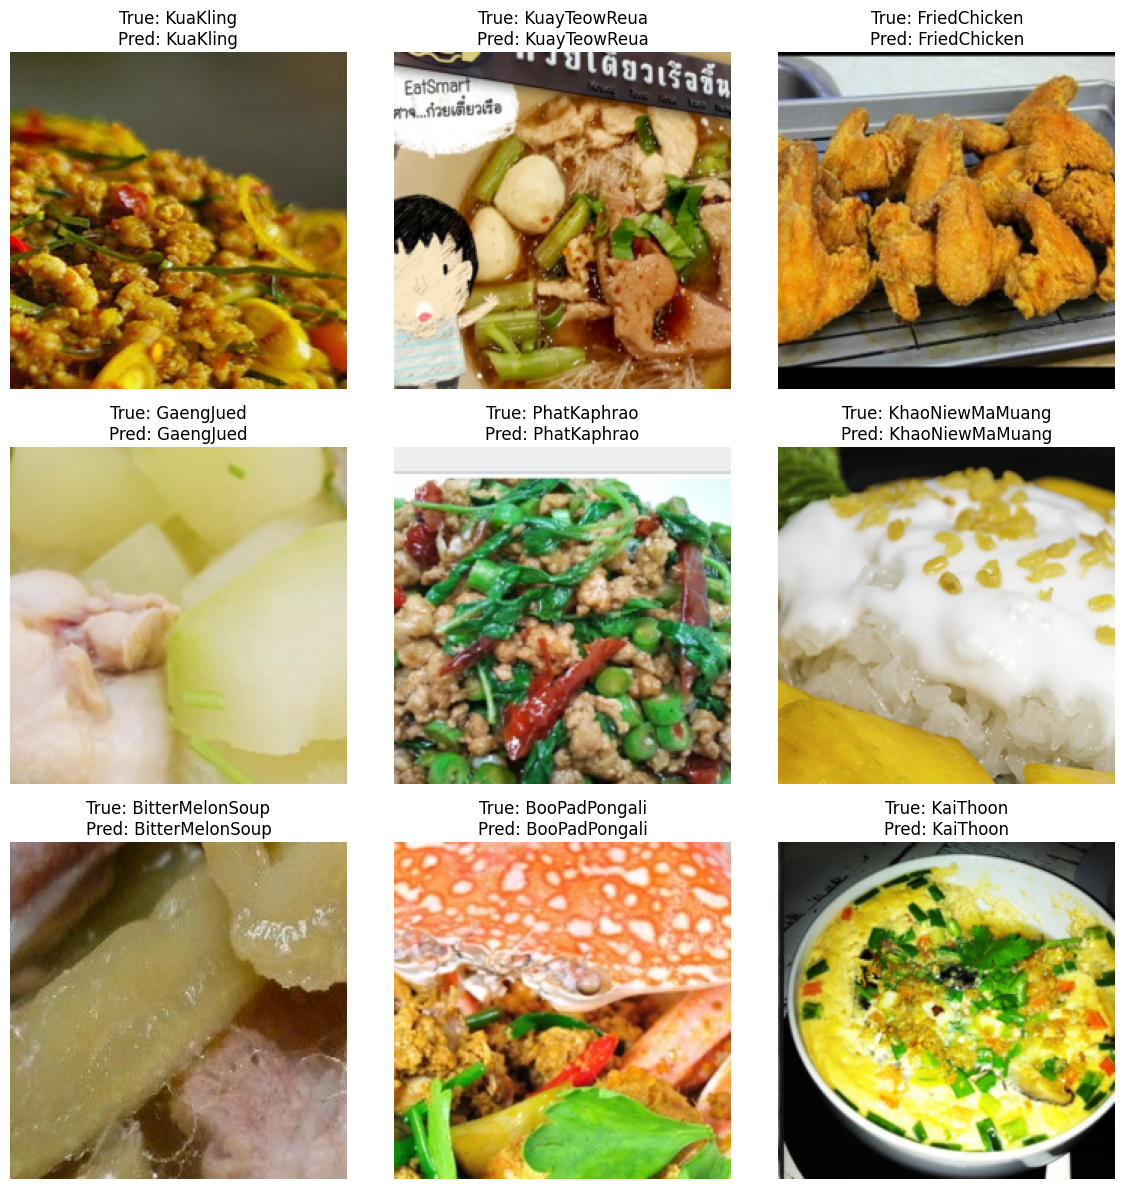

In [15]:
batch_x, batch_y = next(iter(train_dl))
y_hat = model(batch_x.to(device))
y_pred = torch.argmax(y_hat, dim=1)  # this is optional
print(y_hat)
print(y_pred)  # this is optional

plot_predictions(batch_x, batch_y, y_pred, train_ds.classes)